# Proposal Topic Modelling

#### Initial Imports

In [1]:
# Import libs
import json
import os
import pandas as pd
import re
import pickle

#### Create DataFrame & do Text Processing

In [2]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess

# Import files, Create DF 
directory = './jsons/'
df = pd.DataFrame(columns=["Filename", "Text"])

# Add staff names, place name stopwords to remove from the corpus
staff = ["Andrew Hellman","John Butt","Charlie Petersen","Conrad Ramirez","Doug Johnson","Eric Bodenstab",
         "Mary Boechler","Matt Henderson","Mridhula Manoj","Lindsey Wickman","Luis Acosta","Erik Carlson",
         "Paul Deutsch","Jen Hanley","J. Luke Hodges","Will Kerns","Abdullah Kurkcu","Nikki Olson","Bob Smith",
         "Ron Lowe","Angela Eickelman","Robbert Wieder","Jason Berner","Rebecca Berner","Molly Thiebaut",
         "Joseph El- Hehiawy","Mustafa Al Ogaila","Bill Mischlich","Dave Wieder","Gabe Maliscke","Clint Knutson",
         "Don Nelson","Dominique Lopez","Grant Seger","Chad Stensland","Corey Maynard","Jason Orban","Morgan Wrasper",
         "Nick State","Carter Dahl","Jimmy Coffee","Brad Stangohr","Alex Ranz","AJ Tuck","Brad Niemela",
         "Dustin Kulseth","Marty Jenson","Jon Yocom","Brandon Bucholz","Bennett Pederson","Casey Bekkerus",
         "Chris Greve","Chris Smaaladen","Joe Wade","Justin Johnson","Lyle Zeren","Naga Talluri","Paul Pebler",
         "Reece Skarie","Thomas Reisdorf","Travis Berends","Travis DeJong","Zak Grabowski","Paul Moreau",
         "Steve Windish","Kory Kleinknecht","John Kilpatrick","Daylin Gray","Thomas Fakler","Josh Kueber",
         "Laeken Carey","Clark Roberts","Rachel Heinzen","Melanie Muncy","Tanner Blinsky","Sawyer Kenney",
         "Luke Arnold","Rick Archer","Roger Clay","Brett Lovro","Brian Hiles","Charlie Bechtold","Cassie Borden","Jordon Gall"]

city_county = ['Ulteig','city','county','town','CDOT', 'Adams', 'Arapahoe', 'Arvada', 'Boulder', 'Brighton', 'Broomfield', 'Buena Vista', 'Castle Pines', 
               'Castle Rock', 'Centennial', 'Clear Creek', 'Commerce City', 'Denver', 'Englewood', 'Federal Heights',
              'Fort Morgan', 'Greeley', 'Greenwood Village', 'Jefferson', 'Lafayette', 'Lochbuie', 'Mesa', 'Northglenn', 'Parker',
              'Steamboat', 'Superior', 'Vail', 'Weld', 'Westminster', 'Windsor']

staff = [x.lower() for x in staff]
city_county = [x.lower() for x in city_county]

# Iterate over files in the directory & remove staff members/places 
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    text = ""
    
    # Dump to file
    with open(f, "r") as json_file: 
        data = json.load(json_file)
        
    for key in data:
        x = data[key].lower()
        key = key.lower()
        for member in staff:
            x = x.replace(member.lower(), ' ')
            key = key.replace(member.lower(), ' ')
        for city in city_county:
            x = x.replace(city.lower(), ' ')
            key = key.replace(city.lower(), ' ')
        text = text + " " + key + " " + x
        
    filename = filename.rstrip(".json")
    df = df.append({"Filename":filename, "Text":text}, ignore_index=True)

# Convert the titles to lowercase
df['Text'] = df['Text'].map(lambda x: x.lower())

# Remove punctuation
df['Text'] = df['Text'].map(lambda x: re.sub('[,\.!?&]', '', x))

# Get stopwords list
stop_words = stopwords.words('english')
stop_words.extend(['design', 'project', 'ulteig', 'team', 'projects', 'nd'])    # Note - add or remove misc. stopwords here

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.Text.values.tolist()
data_words = list(sent_to_words(data))

# Remove stop words
data_words = remove_stopwords(data_words)

#print("some example text data:", data_words[:1][0][:100])

C:\Users\helen.schawe\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# LDA Topic Modelling

#### choose number of topics for the LDA topic model

In [3]:
%%time
# Use coherence score to get ideal num. of topics for LDA model
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore


def find_num_topics(num_topics_list):
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    for num_topics in num_topics_list:
        # Build LDA model
        lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=1)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print("Num. Topics: ", num_topics, ', LDA Coherence Score: ', round(coherence_lda, 4), sep="")
    return


num_topics_list = list(range(1,9))    
find_num_topics(num_topics_list)

Num. Topics: 1, LDA Coherence Score: 0.3538
Num. Topics: 2, LDA Coherence Score: 0.3337
Num. Topics: 3, LDA Coherence Score: 0.3359
Num. Topics: 4, LDA Coherence Score: 0.3469
Num. Topics: 5, LDA Coherence Score: 0.3413
Num. Topics: 6, LDA Coherence Score: 0.3414
Num. Topics: 7, LDA Coherence Score: 0.3414
Num. Topics: 8, LDA Coherence Score: 0.3263
Wall time: 3min 5s


#### Run LDA model

In [4]:
import gensim.corpora as corpora
#import pyLDAvis.gensim_models as gm    # Uncomment this import for pyLDAvis versions > 3.2.2
import pyLDAvis.gensim as gm    # Uncomment this import for pyLDAvis-version = 3.2.2
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

import pickle 
import pyLDAvis

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


def create_LDA_model(data_words, num_topics):
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Run LDA Topic Modelling
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=1)

    return lda_model, id2word, corpus


def LDA_coherence_score(lda_model, data_words, id2word):
    # Get Coherence Score - for the above LDA model
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('LDA Coherence Score: ', round(coherence_lda, 4))
    return


def LDA_wordcloud(num_topics, num_words=20):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    topics = lda_model.show_topics(num_topics=5, num_words=num_words, formatted=False)

    # Note - change first 2 numbers (row, cols) when changing num. of topics
    fig, axes = plt.subplots(1, num_topics, figsize=(15,15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud = WordCloud(stopwords=stop_words, background_color='white', width=2500, height=1800, max_words=20, colormap='tab10', \
                          color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=14))
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    return


def LDA_topic_map(lda_model, corpus, id2word):
    # Visualize the topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join('ldavis_prepared_' + str(num_topics))

    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = gm.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
    return LDAvis_prepared

    
num_topics = 5    # <--- Change number of topics here

lda_model, id2word, corpus = create_LDA_model(data_words, num_topics)
LDA_coherence_score(lda_model, data_words, id2word)
#LDA_wordcloud(num_topics)
LDA_topic_map(lda_model, corpus, id2word)

LDA Coherence Score:  0.3342


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.002856 -0.001246       1        1  45.730132
4     -0.001322  0.000663       2        1  19.433726
1      0.002003 -0.000760       3        1  13.141816
2      0.001663 -0.001605       4        1  12.862561
0      0.000512  0.002948       5        1   8.831765, topic_info=              Term         Freq        Total Category  logprob  loglift
235   construction  3870.000000  3870.000000  Default  30.0000  30.0000
1110       traffic  2312.000000  2312.000000  Default  29.0000  29.0000
401     experience  2852.000000  2852.000000  Default  28.0000  28.0000
641     management  1639.000000  1639.000000  Default  27.0000  27.0000
370    engineering  2030.000000  2030.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1197          work   113.302173  1615.911541   Topic5  -5.6744  -0.2308
1213         years   103.243963  1294.467831   Topic5  -5.7673  -0.1019
134         bridge   100.165462  1489.385328   Topic5  -5.7976  -0.2725
855        provide    94.596345  1208.122163   Topic5  -5.8548  -0.1204
838        process    93.113025  1174.696112   Topic5  -5.8706  -0.1081

[477 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
10878      1  0.570083      abe
3          1  0.459622   access
3          2  0.200872   access
3          3  0.112352   access
3          4  0.149803   access
...      ...       ...      ...
9185       2  0.127523      yes
9185       3  0.255047      yes
9185       4  0.255047      yes
9185       5  0.127523      yes
6580       1  0.557598  zealand

[1281 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1])

# NMF Topic Modelling (better for texts w similar topics)

#### Use Gensim NMF package to find best # of topics

In [5]:
%%time
# Run NMF with Gensim to find the Coherence Scores & decide num. topics to use
import gensim.corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf


def NMF_num_topics(df):
    # Getting the data
    data = df.Text.values.tolist()
    data_words = list(sent_to_words(data))
    data_words = remove_stopwords(data_words)
    texts = data_words

    # Create a dictionary
    id2word = Dictionary(data_words)

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Create a list of the topic numbers we want to try
    topic_nums = list(range(2,10))

    # Run the nmf model and calculate the coherence score for each number of topics
    coherence_scores = {}
    for num in topic_nums:

        print("# of Topics:", num, end=", ")

        nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=id2word,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=42
        )

        # Run the coherence model to get the score
        cm = CoherenceModel(
            model=nmf,
            texts=texts,
            dictionary=id2word,
            coherence='c_v'
        )

        coherence_score = round(cm.get_coherence(), 5)
        print("Coherence score:", coherence_score)
    return


NMF_num_topics(df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# of Topics: 2, Coherence score: 0.33329
# of Topics: 3, Coherence score: 0.33259
# of Topics: 4, Coherence score: 0.33795
# of Topics: 5, Coherence score: 0.34499
# of Topics: 6, Coherence score: 0.33471
# of Topics: 7, Coherence score: 0.34265
# of Topics: 8, Coherence score: 0.33695
# of Topics: 9, Coherence score: 0.34507
Wall time: 1min 55s


#### Run sklearn NMF package to create Topic Model

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


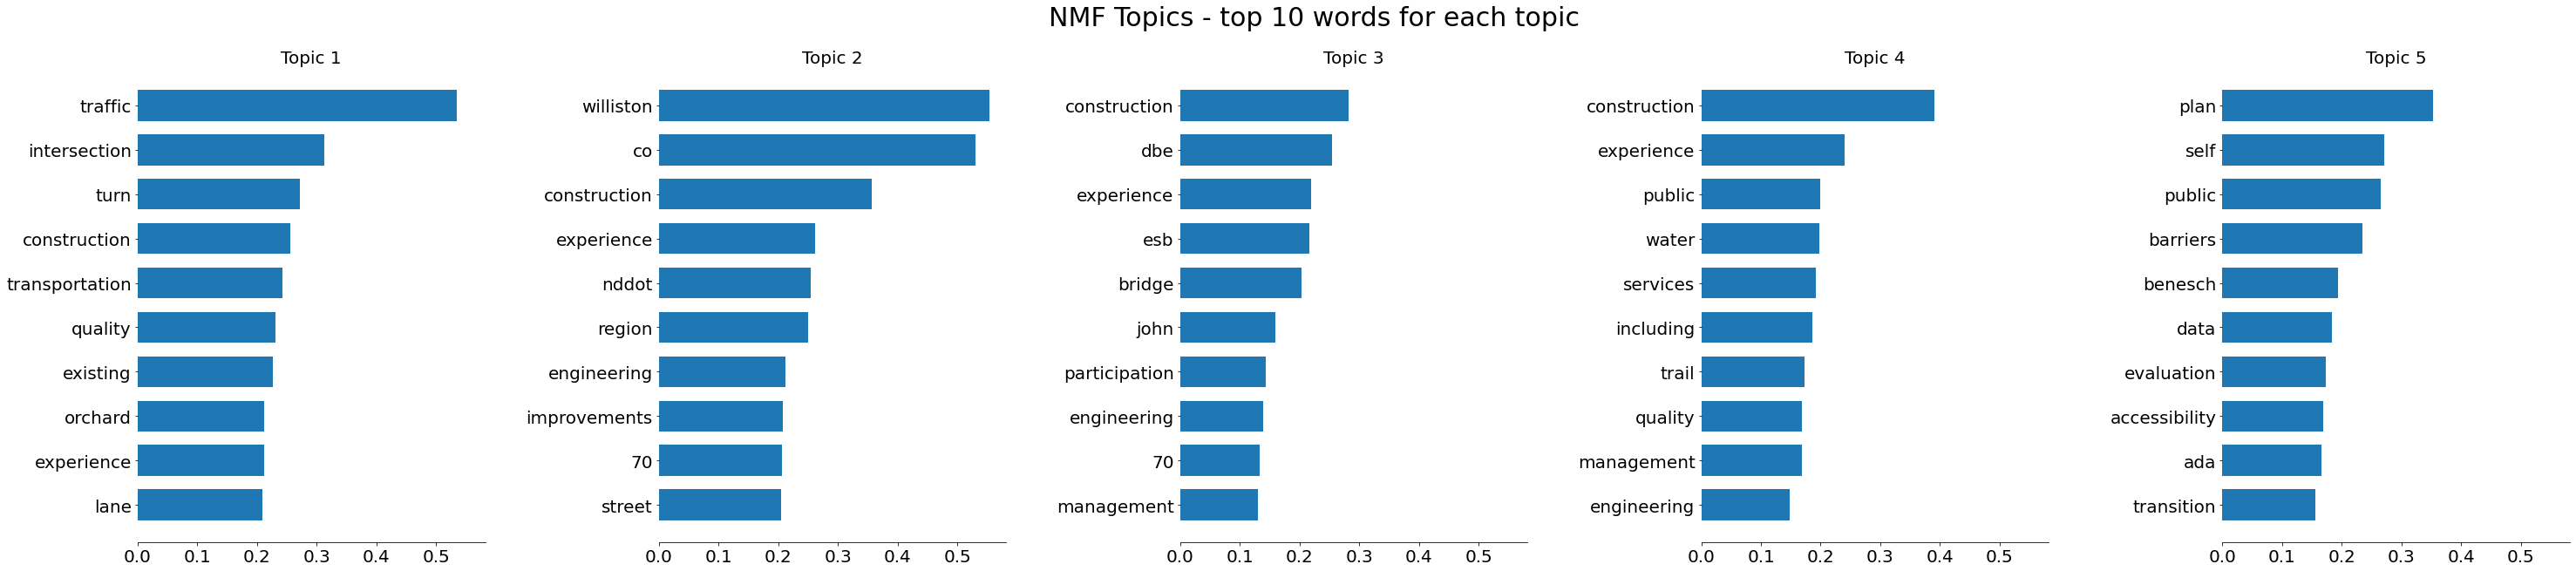

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from matplotlib import pyplot as plt


def create_NMF_model(df, stop_words, num_topics=5):
    # TF IDF
    texts = df['Text']
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
    tfidf = tfidf_vectorizer.fit_transform(texts)
    tfidf.toarray()

    # NMF - Input: change n_components to desired number of topics
    nmf_model = NMF(n_components=num_topics)
    nmf_model.fit(tfidf)
    
    return nmf_model, tfidf_vectorizer


def NMF_vis(tfidf_vectorizer, n_top_words = 10):
    title = "NMF Topics - top " + str(n_top_words) + " words for each topic"

    # plot top 10 words for each topic
    feature_names = tfidf_vectorizer.get_feature_names()
    fig, axes = plt.subplots(1, 5, figsize=(50, 10), sharex=True)    # Note - change (rows, cols) to match num. topics
    axes = axes.flatten()
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(wspace=0.50)
    plt.show()
    return


num_topics = 5    # <--- Change num. topics here
nmf_model, tfidf_vectorizer = create_NMF_model(df, stop_words, num_topics)
NMF_vis(tfidf_vectorizer)